In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt
#from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


# import dataset
dfPhiladelphia = pd.read_csv("data/exports/dfPhiladelphia.csv.zip")
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589215 entries, 0 to 589214
Data columns (total 33 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   start_date                              589215 non-null  object 
 1   end_date                                589215 non-null  object 
 2   start_time_hourly                       589215 non-null  int64  
 3   end_time_hourly                         589215 non-null  int64  
 4   start_station_id                        589215 non-null  int64  
 5   end_station_id                          589215 non-null  int64  
 6   bike_id                                 589215 non-null  int64  
 7   start_latitude                          589215 non-null  float64
 8   start_longitude                         589215 non-null  float64
 9   end_latitude                            589215 non-null  float64
 10  end_longitude                           5892

# 4. Predictive Analytics

- Since the **total system-level demand in the next hour** is of our interest, the station-dependent demand is not needed in this task.
- Our target value is `y = numOfRentedBikes`

## 4.1 Feature Engineering

In this subtask, we will:
- Develop a rich set of features that we expect to be correlated with our target
- We will justify the selection of features

#### Creating the dataframe we need for our predicition.

In [2]:
# test for duplicates in start_date and start_time_hourly
len(dfPhiladelphia)-len(dfPhiladelphia.drop_duplicates(subset = ['start_date', 'start_time_hourly']))

580651

In [3]:
# drop the above checked duplicates, because we predict hourly
dfPhiladelphia.drop_duplicates(inplace=True, ignore_index = True,subset = ['start_date', 'start_time_hourly'])

In [4]:
# delete the last row of dfPhiladelphia, because its value is from 2020
dfPhiladelphia = dfPhiladelphia[:-1]

In [5]:
dfPhiladelphia['start_date'] = pd.to_datetime(dfPhiladelphia['start_date'])

In [6]:
dfPhiladelphia['start_day'] = dfPhiladelphia['start_date'].dt.day

In [7]:
dfPhiladelphia = dfPhiladelphia[['start_month', 'start_day', 'start_time_hourly', 'numOfRentedBikesHourly']]
dfPhiladelphia['year'] = 2019
dfPhiladelphia.rename(columns={"start_day": "day", "start_month": "month", "start_time_hourly": "hour"}, 
                      inplace = True)
dfPhiladelphia['date'] = pd.to_datetime(dfPhiladelphia[['year', 'month', 'day','hour']])
dfPhiladelphia

,month,day,hour,numOfRentedBikesHourly,year,date
0,1,1,0,2,2019,2019-01-01 00:00:00
1,1,1,1,8,2019,2019-01-01 01:00:00
2,1,1,2,10,2019,2019-01-01 02:00:00
3,1,1,3,7,2019,2019-01-01 03:00:00
4,1,1,4,3,2019,2019-01-01 04:00:00
...,...,...,...,...,...,...
8558,12,31,19,44,2019,2019-12-31 19:00:00
8559,12,31,20,33,2019,2019-12-31 20:00:00
8560,12,31,21,24,2019,2019-12-31 21:00:00
8561,12,31,22,26,2019,2019-12-31 22:00:00


In [8]:
# import dfWeather and edit it
dfWeather = pd.read_csv("data/exports/dfWeather.csv")
dfWeather['date_time'] = pd.to_datetime(dfWeather['date_time'])
dfWeather = dfWeather[:-1]
dfWeather

,date_time,max_temp,min_temp,isPrecip
0,2019-01-01 00:00:00,6.950,6.4,True
1,2019-01-01 01:00:00,7.075,6.8,True
2,2019-01-01 02:00:00,7.200,7.2,True
3,2019-01-01 03:00:00,8.050,7.8,True
4,2019-01-01 04:00:00,9.400,8.3,True
...,...,...,...,...
8755,2019-12-31 19:00:00,7.375,7.1,False
8756,2019-12-31 20:00:00,7.800,7.8,False
8757,2019-12-31 21:00:00,8.300,8.3,False
8758,2019-12-31 22:00:00,8.300,8.3,False


In [9]:
# merge dfWeather and dfPhiladelphia
dfPhiladelphia = dfPhiladelphia[['date', 'numOfRentedBikesHourly']]
dfPhiladelphia = dfPhiladelphia.merge(dfWeather, left_on=["date"], 
                                      right_on=["date_time"], how="right")
dfPhiladelphia.drop(columns = ['date'], inplace = True)
dfPhiladelphia

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip
0,2.0,2019-01-01 00:00:00,6.950,6.4,True
1,8.0,2019-01-01 01:00:00,7.075,6.8,True
2,10.0,2019-01-01 02:00:00,7.200,7.2,True
3,7.0,2019-01-01 03:00:00,8.050,7.8,True
4,3.0,2019-01-01 04:00:00,9.400,8.3,True
...,...,...,...,...,...
8755,44.0,2019-12-31 19:00:00,7.375,7.1,False
8756,33.0,2019-12-31 20:00:00,7.800,7.8,False
8757,24.0,2019-12-31 21:00:00,8.300,8.3,False
8758,26.0,2019-12-31 22:00:00,8.300,8.3,False


**FEATURE: `daOfWeek`**

In [10]:
# creating dayOfWeek
dfPhiladelphia['dayOfWeek'] = pd.to_datetime(dfPhiladelphia["date_time"]).dt.day_name()
dfPhiladelphia.head()

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday


**FEATURE: `isWeekend`**

In [11]:
def isWeekend(dayOfWeek):
    if(dayOfWeek in ["Saturday","Sunday"]):
        return True
    else:
        return False

In [12]:
dfPhiladelphia["isWeekend"] = dfPhiladelphia["dayOfWeek"].map(isWeekend)

**FEATURE: `isHoliday`**
- You need to install holidays

In [13]:
from datetime import date
import holidays

# Select country
us_holidays = holidays.US()
us_holidays

holidays.country_holidays('US')

In [14]:
dfPhiladelphia = dfPhiladelphia.assign(isHoliday=lambda x: x["date_time"].dt.date.apply(lambda h: h in us_holidays))

**FEATURE: `season`**

In [15]:
# Returns the day of the year
def day_match(ts):
    return pd.Period(ts, freq='D').day_of_year

#seasons = {'spring': (start='2019-03-20', end='2019-06-20'),
#           'summer': (start='2019/06/21', end='2019/09/22'),
#           'autumn': (start='2019/09/23', end='2019/12/21'),
#           'winter': rest}

# Create Array to map days to seasons (1 - 4)
seasons = ['winter' for i in range(0,78)]
seasons.extend('spring' for i in range(0,93))
seasons.extend('summer' for i in range(0,94))
seasons.extend('autumn' for i in range(0,90))
seasons.extend('winter' for i in range(0,10))

# Create dictionary for lambda expression
day_to_season = {}
for i in range(0,365):
    day_to_season[i+1] = seasons[i]
    
# Map start_date to day of the year (day_match) and afterwards map this to seasonnames (day_to_season)
dfPhiladelphia["season"] = dfPhiladelphia["date_time"].map(day_match).map(day_to_season)

In [16]:
print("In 2019 there were:\n", 
      "•", pd.Period("2019-03-19").day_of_year + (pd.Period("2019-12-31").day_of_year - pd.Period("2019/12/21").day_of_year), "winter days\n", 
      "•", pd.Period("2019/06/20").day_of_year - pd.Period("2019-03-19").day_of_year, "spring days\n",
      "•", pd.Period("2019/09/22").day_of_year - pd.Period("2019/06/20").day_of_year, "summer days\n",
      "•", pd.Period("2019/12/21").day_of_year - pd.Period("2019/09/22").day_of_year, "autumn days\n")

In 2019 there were:
 • 88 winter days
 • 93 spring days
 • 94 summer days
 • 90 autumn days



**FEATURE: `isRushhour`**
- Wikipedia: Rush hour may be 5–9 AM (5:00–9:00) and 4–8 PM (sometimes from 4-9 PM) (16:00–20:00 (sometimes from 16:00-21:00))
- TomTom: https://www.tomtom.com/traffic-index/philadelphia-traffic/#:~:text=2020-,2019,-Best%20time%20to
- We took the TomTom statistics for deciding, when rushhour is starting and ending, since it is tailored for Philadelphia 2019 traffic

In [17]:
# Create feature isRushour
def isRushhour(time):
    if (time in [7,8,9,16,17,18,19]):
        return True
    else: 
        return False

dfPhiladelphia['isRushhour'] = dfPhiladelphia['date_time'].dt.hour.apply(lambda x:isRushhour(x))
dfPhiladelphia.head()

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday,False,True,winter,False
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday,False,True,winter,False
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday,False,True,winter,False
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday,False,True,winter,False
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday,False,True,winter,False


In [18]:
dfPhiladelphia

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday,False,True,winter,False
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday,False,True,winter,False
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday,False,True,winter,False
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday,False,True,winter,False
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday,False,True,winter,False
...,...,...,...,...,...,...,...,...,...,...
8755,44.0,2019-12-31 19:00:00,7.375,7.1,False,Tuesday,False,False,winter,True
8756,33.0,2019-12-31 20:00:00,7.800,7.8,False,Tuesday,False,False,winter,False
8757,24.0,2019-12-31 21:00:00,8.300,8.3,False,Tuesday,False,False,winter,False
8758,26.0,2019-12-31 22:00:00,8.300,8.3,False,Tuesday,False,False,winter,False


**FEATURE: `start_month`, `start_day` and `start_time_hourly`**

In [19]:
#splitting date_time into month, day and hour
dfPhiladelphia['start_day'] = dfPhiladelphia['date_time'].dt.day
dfPhiladelphia['start_month'] = dfPhiladelphia['date_time'].dt.month
dfPhiladelphia['start_time_hourly'] = dfPhiladelphia['date_time'].dt.hour
dfPhiladelphia.drop(columns = ['date_time'], inplace = True)
dfPhiladelphia

,numOfRentedBikesHourly,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour,start_day,start_month,start_time_hourly
0,2.0,6.950,6.4,True,Tuesday,False,True,winter,False,1,1,0
1,8.0,7.075,6.8,True,Tuesday,False,True,winter,False,1,1,1
2,10.0,7.200,7.2,True,Tuesday,False,True,winter,False,1,1,2
3,7.0,8.050,7.8,True,Tuesday,False,True,winter,False,1,1,3
4,3.0,9.400,8.3,True,Tuesday,False,True,winter,False,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,44.0,7.375,7.1,False,Tuesday,False,False,winter,True,31,12,19
8756,33.0,7.800,7.8,False,Tuesday,False,False,winter,False,31,12,20
8757,24.0,8.300,8.3,False,Tuesday,False,False,winter,False,31,12,21
8758,26.0,8.300,8.3,False,Tuesday,False,False,winter,False,31,12,22


#### Replace null values

In [20]:
# replace null values by zero (in numOfRentedBikesHourly)
dfPhiladelphia.fillna(0, inplace = True)

The feature creation process was already done in task 1: This are all features which we created in Task 1

In [21]:
dfPhiladelphia['dayOfWeek'] = dfPhiladelphia['dayOfWeek'].replace(['Monday', 'Tuesday','Wednesday','Thursday',
                                                                  'Friday','Saturday','Sunday'],[0,1,2,3,4,5,6])
dfPhiladelphia['season'] = dfPhiladelphia['season'].replace(['summer', 'winter','spring','autumn'],[0,1,2,3])


dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   numOfRentedBikesHourly  8760 non-null   float64
 1   max_temp                8760 non-null   float64
 2   min_temp                8760 non-null   float64
 3   isPrecip                8760 non-null   bool   
 4   dayOfWeek               8760 non-null   int64  
 5   isWeekend               8760 non-null   bool   
 6   isHoliday               8760 non-null   bool   
 7   season                  8760 non-null   int64  
 8   isRushhour              8760 non-null   bool   
 9   start_day               8760 non-null   int64  
 10  start_month             8760 non-null   int64  
 11  start_time_hourly       8760 non-null   int64  
dtypes: bool(4), float64(3), int64(5)
memory usage: 650.2 KB


**Remove unnecessary features**

We won't need:
- 'end_date', because
- 'end_time_hourly', because
- 'start_station_id', because we are interested in the **total system-level demand in the next hour**
- 'end_station_id', because
- 'start_latitude', because
- 'start_longitude', because
- 'end_latitude', because
- 'end_longitude', because
- 'start_station_name', because
- 'end_station_name', because
- 'tripduration_sec', because

We will need:
- 'start_date', because
- 'start_time_hourly', because
- 'numOfRentedBikes', because

We will test/evaluate if we need the following features, in a later step (x.x.x):
- 'min_temp', because
- 'max_temp', because
- 'precip', because
- 'user_type', because
- 'dayOfWeek', because
- 'isWeekend', because
- 'season', because
- 'isHoliday', because
- 'isRushhour', because
- #'tripLengthDistance', because

In [22]:
#Take only necessary columns (implicit drop of unselected columns)
dfPhiladelphia = dfPhiladelphia[['start_month', 'start_day', 'start_time_hourly', 'dayOfWeek',
                                'isWeekend', 'isHoliday', 'season', 'isRushhour','max_temp', 
                                 'min_temp', 'isPrecip','numOfRentedBikesHourly']]

### 4.1.1 Dummy Feature Creation (maybe after evaluation)
- We already created all features we need in Task 1, but we need to change some features into dummy variables to assure predictive performance

In [23]:
# here just 2 blocks of code

### 4.1.2 Justify the selection of features 

In [24]:
# Variance criteria or correlation criteria or filtering or embedded methods
# we will take variance & correlations

#### Variance:

In [25]:
#### take out features which will become dummys
#### season and so on missing, but we do know the variance because, we defined it
dfPhiladelphia[['start_time_hourly', 'min_temp', 'max_temp', 'isPrecip', 'dayOfWeek', 'isWeekend', 'isHoliday', 'isRushhour', 'numOfRentedBikesHourly']].var()

start_time_hourly           47.922137
min_temp                   103.864476
max_temp                   104.211228
isPrecip                     0.078957
dayOfWeek                    4.000427
isWeekend                    0.203769
isHoliday                    0.026650
isRushhour                   0.206621
numOfRentedBikesHourly    4310.690580
dtype: float64

In [26]:
# min_temp & max_temp same variance => validate if they have different values

#### Correlations

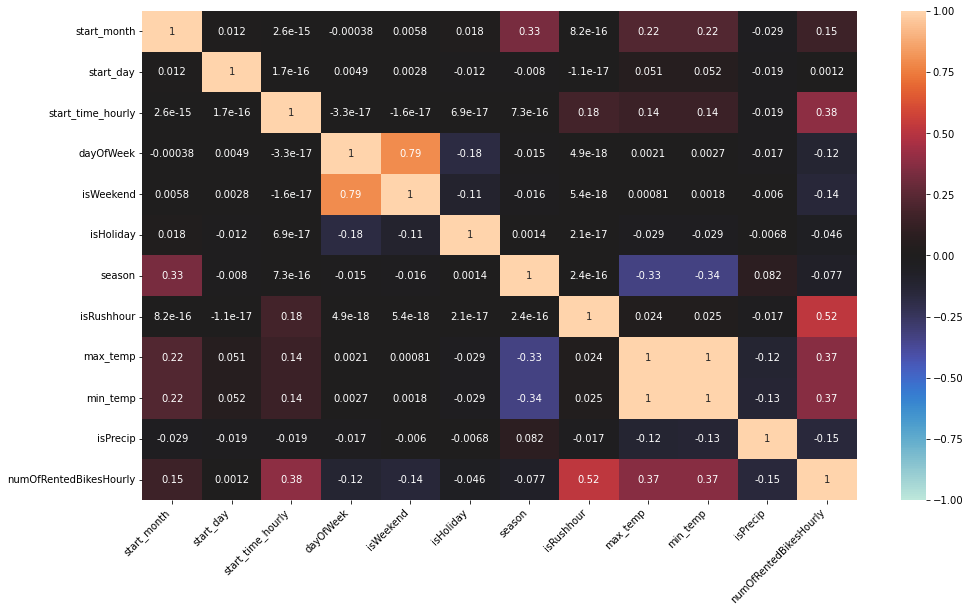

In [27]:
######## make named features like season to 0/1/2/3 so they show up here, before we make them a dummy variable like hours
import seaborn as sns
corr = dfPhiladelphia.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

#### ISSUMMER ETC ADDEN, user_type, (start_month)

#### Feature selection:
 
We will drop `max_temp` or `min_temp`, because they are perfectly correlated.

In [28]:
dfPhiladelphia.drop(columns = ['min_temp'], inplace = True)

### 4.1.3 (Visualisation of dependencies)

## 4.2 Model Building & Evaluation

In [29]:
# function for normalize numeric and encode categorical features and for create pipeline

def pipeline_for_prediction(categoric, numeric, model):
    
    numeric_transformer = Pipeline(steps=[("standard_scaler", StandardScaler())])
    categorical_transformer = Pipeline(
        steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical scaler", numeric_transformer, numeric),
            ("one hot encoder", categorical_transformer, categoric),
        ]
    )
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    return pipeline

In [30]:
# defining categorical and numeric features of dfPhiladelphia

categoric = ['isPrecip', 'start_time_hourly','dayOfWeek','isWeekend','start_month','start_day','season',
             'isHoliday','isRushhour']
numeric = ['max_temp']


In [31]:
# function for getting different scores for a model

def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"Accuracy:", round((1-(metrics.mean_absolute_error(y_true, y_predicted)/dfPhiladelphia["numOfRentedBikesHourly"].mean()))*100,2), "%")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [32]:
# function for creating pipeline and fitting model (created by the pipeline), predict and printing scores

def pipeline_fit_predict(reg, categoric, numeric, x_train, y_train, x_val, y_val):
    pipeline = pipeline_for_prediction(categoric, numeric, reg)
    pipeline.fit(x_train, y_train)
    y_predict = pipeline.predict(x_val)
    get_prediction_scores(y_val, y_predict)

**Split the dataset in trainset, validationset and testset (50-20-30)**

In [33]:
from sklearn.model_selection import train_test_split

#split the data set in 70% training set and 30% testing set
#x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(dfPhiladelphia.drop('numOfRentedBikesHourly', axis=1)
                                                    , dfPhiladelphia['numOfRentedBikesHourly'], 
                                                    test_size=0.3,random_state=42)

# save the combination of training and validation set in extra variables
x_train_val = x_train
y_train_val = y_train

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model
- x_train_val, y_train_val &rarr; 70% input features for training the model

### 4.2.1 First Regression: Linear Regression (as Benchmark)

Using Linear Regression to predict the `numOfRentedBikesHourly`.

In [34]:
# creating the regression model

lin_reg = LinearRegression()

In [35]:
pipeline = pipeline_fit_predict(lin_reg, categoric, numeric, x_train_val, y_train_val, x_test, y_test)

MODEL SCORES:
MAE:  26.883
MSE:  1358.167
RMSE:  36.853
Accuracy: 60.03 %
R2:  69.548 %
Max Residual Error:  182.355


### 4.2.2 Second Regression: Decision Tree

Using Decision Tree Regression to predict the `numOfRentedBikesHourly`.

In [36]:
# creating the regression model

tree_reg = DecisionTreeRegressor(criterion="friedman_mse", random_state=42) 

In [37]:
#pipeline = pipeline_fit_predict(tree_reg, categoric, numeric, x_train, y_train, x_val, y_val)

**Looking for the best Hyperparameters**

In [38]:
# function for finding the best hyperparameter by using RandomizedSearchCV and RepeatedStratifiedKFold
"""parameter:
   - pipeline: used pipeline for grid search (the pipeline contains the model)
   - x_val: data set (features) used for grid search
   - y_val: data set (target value) used for grid search
   - model_par: parameters for which the grid search is done
   - score: used score measure 
   - n_iter: how often grid search will be done
   - n_repeats: how often the data set is randomly splitted (by using the same random hyperparameter) in n_splits
   - n_splits: number of splits in RepeatedStratifiedKFold
   - verbose: getting information during the grid search
"""


from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

def find_best_hyperparameters(pipeline, x_val, y_val, model_par, score, n_iter = 50,  
                                   n_repeats=3, n_splits=5, n_jobs=1, verbose=True):
    
    print(f"Running grid search for the model based on {score}")
    grid_pipeline = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=model_par,
        n_jobs=n_jobs,
        n_iter=n_iter,
        cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42),
        scoring=score,
        random_state=42,
        verbose=verbose,
    )
    grid_pipeline.fit(x_val, y_val)
    print(f"Best {score} Score was: {grid_pipeline.best_score_}")
    print("The best hyper parameters for the model are:")
    print(grid_pipeline.best_params_)

In [39]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform

model_para = {'model__max_depth': range(1,51),
              'model__ccp_alpha': loguniform(1e-4, 40e-1)
             }

In [40]:
pipeline = pipeline_for_prediction(categoric, numeric, tree_reg)
#pipeline

In [41]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 1/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-928.519 total time=   0.0s
[CV 2/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 2/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1035.688 total time=   0.0s
[CV 3/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 3/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1251.255 total time=   0.0s
[CV 4/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 4/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1326.718 total time=   0.0s
[CV 5/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 7/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1234.399 total time=   0.0s
[CV 8/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 8/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1675.659 total time=   0.0s
[CV 9/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 9/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1182.494 total time=   0.0s
[CV 10/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 10/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1170.543 total time=   0.0s
[CV 11/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 11/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1120.594 total time=   0.0s
[CV 12/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 12/15;

[CV 7/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1295.467 total time=   0.0s
[CV 8/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 8/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1755.935 total time=   0.0s
[CV 9/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 9/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1263.935 total time=   0.0s
[CV 10/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 10/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1158.820 total time=   0.0s
[CV 11/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 11/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1114.795 total time=   0.0s
[CV 12/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 12/15;

[CV 7/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1119.392 total time=   0.0s
[CV 8/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 8/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1448.661 total time=   0.0s
[CV 9/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 9/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1276.312 total time=   0.0s
[CV 10/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22
[CV 10/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1343.851 total time=   0.0s
[CV 11/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22
[CV 11/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1089.342 total time=   0.0s
[CV 12/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22
[CV 12/15; 7/50] E

[CV 5/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-890.740 total time=   0.0s
[CV 6/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 6/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-1300.856 total time=   0.0s
[CV 7/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 7/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-1255.891 total time=   0.0s
[CV 8/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 8/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-1606.400 total time=   0.0s
[CV 9/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 9/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-1065.151 total time=   0.0s
[CV 10/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model

[CV 5/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-897.969 total time=   0.0s
[CV 6/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth=42
[CV 6/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-1380.395 total time=   0.0s
[CV 7/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth=42
[CV 7/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-1248.924 total time=   0.0s
[CV 8/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth=42
[CV 8/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-1656.922 total time=   0.0s
[CV 9/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth=42
[CV 9/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-1152.081 total time=   0.0s
[CV 10/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_dept

[CV 1/15; 16/50] END model__ccp_alpha=0.07012122794606233, model__max_depth=44;, score=-1059.495 total time=   0.0s
[CV 2/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[CV 2/15; 16/50] END model__ccp_alpha=0.07012122794606233, model__max_depth=44;, score=-1033.435 total time=   0.0s
[CV 3/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[CV 3/15; 16/50] END model__ccp_alpha=0.07012122794606233, model__max_depth=44;, score=-1253.939 total time=   0.0s
[CV 4/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[CV 4/15; 16/50] END model__ccp_alpha=0.07012122794606233, model__max_depth=44;, score=-1309.456 total time=   0.0s
[CV 5/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[CV 5/15; 16/50] END model__ccp_alpha=0.07012122794606233, model__max_depth=44;, score=-888.777 total time=   0.0s
[CV 6/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[CV 6/15; 16/50]

[CV 2/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1054.234 total time=   0.0s
[CV 3/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39
[CV 3/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1237.463 total time=   0.0s
[CV 4/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39
[CV 4/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1307.598 total time=   0.0s
[CV 5/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39
[CV 5/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1007.265 total time=   0.0s
[CV 6/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39
[CV 6/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1379.680 total time=   0.0s
[CV 7/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_dept

[CV 14/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-1106.887 total time=   0.0s
[CV 15/15; 21/50] START model__ccp_alpha=2.7790511850146156, model__max_depth=50
[CV 15/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-950.079 total time=   0.0s
[CV 1/15; 22/50] START model__ccp_alpha=0.005938952698993865, model__max_depth=26
[CV 1/15; 22/50] END model__ccp_alpha=0.005938952698993865, model__max_depth=26;, score=-976.236 total time=   0.0s
[CV 2/15; 22/50] START model__ccp_alpha=0.005938952698993865, model__max_depth=26
[CV 2/15; 22/50] END model__ccp_alpha=0.005938952698993865, model__max_depth=26;, score=-1030.399 total time=   0.0s
[CV 3/15; 22/50] START model__ccp_alpha=0.005938952698993865, model__max_depth=26
[CV 3/15; 22/50] END model__ccp_alpha=0.005938952698993865, model__max_depth=26;, score=-1191.147 total time=   0.0s
[CV 4/15; 22/50] START model__ccp_alpha=0.005938952698993865, model__max_depth=26
[CV 4/15; 

[CV 11/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1327.020 total time=   0.0s
[CV 12/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 12/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1484.877 total time=   0.0s
[CV 13/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 13/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1237.616 total time=   0.0s
[CV 14/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 14/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1581.359 total time=   0.0s
[CV 15/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 15/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1566.290 total time=   0.0s
[CV 1/15; 25/50] START model__ccp_alpha=0.06415658128567595, model__max_depth=

[CV 9/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-1156.743 total time=   0.0s
[CV 10/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 10/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-1214.757 total time=   0.0s
[CV 11/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 11/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-1138.641 total time=   0.0s
[CV 12/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 12/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-1121.584 total time=   0.0s
[CV 13/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 13/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-954.595 total time=   0.0s
[CV 14/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 14/

[CV 6/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1251.734 total time=   0.0s
[CV 7/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 7/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1229.490 total time=   0.0s
[CV 8/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 8/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1669.955 total time=   0.0s
[CV 9/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 9/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1185.624 total time=   0.0s
[CV 10/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 10/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1159.550 total time=   0.0s
[CV 11/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 11/15; 3

[CV 3/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1113.177 total time=   0.0s
[CV 4/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14.
[CV 4/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1150.855 total time=   0.0s
[CV 5/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14.
[CV 5/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-968.073 total time=   0.0s
[CV 6/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14.
[CV 6/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1181.670 total time=   0.0s
[CV 7/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14.
[CV 7/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1115.141 total time=   0.0s
[CV 8/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14.
[CV 8/15; 33/50] END 

[CV 1/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-1066.574 total time=   0.0s
[CV 2/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 2/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-1043.090 total time=   0.0s
[CV 3/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 3/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-1245.875 total time=   0.0s
[CV 4/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 4/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-1310.758 total time=   0.0s
[CV 5/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 5/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-898.691 total time=   0.0s
[CV 6/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 6/

[CV 2/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-1054.177 total time=   0.0s
[CV 3/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 3/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-1237.759 total time=   0.0s
[CV 4/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 4/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-1309.931 total time=   0.0s
[CV 5/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 5/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-898.798 total time=   0.0s
[CV 6/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 6/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-1380.537 total time=   0.0s
[CV 7/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 7/

[CV 15/15; 41/50] END model__ccp_alpha=0.0005761935178124764, model__max_depth=25;, score=-1011.934 total time=   0.0s
[CV 1/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 1/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-887.058 total time=   0.0s
[CV 2/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 2/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-891.706 total time=   0.0s
[CV 3/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 3/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-1067.026 total time=   0.0s
[CV 4/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 4/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-1164.406 total time=   0.0s
[CV 5/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 5/15; 42/50] END m

[CV 6/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1411.447 total time=   0.0s
[CV 7/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 7/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1169.286 total time=   0.0s
[CV 8/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 8/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1770.030 total time=   0.0s
[CV 9/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 9/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1340.291 total time=   0.0s
[CV 10/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 10/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1485.026 total time=   0.0s
[CV 11/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[C

[CV 5/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-898.789 total time=   0.0s
[CV 6/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 6/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1380.537 total time=   0.0s
[CV 7/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 7/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1246.901 total time=   0.0s
[CV 8/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 8/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1658.283 total time=   0.0s
[CV 9/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 9/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1152.001 total time=   0.0s
[CV 10/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 1

**Training & Evaluation of the model with the best hyperparameters**

In [42]:
tree_reg_last = DecisionTreeRegressor(criterion="friedman_mse", ccp_alpha =  2.7790511850146156, max_depth = 50)

In [43]:
pipeline_last = pipeline_fit_predict(tree_reg_last, categoric, numeric, x_train, y_train, x_test, y_test)

MODEL SCORES:
MAE:  17.372
MSE:  795.588
RMSE:  28.206
Accuracy: 74.17 %
R2:  82.162 %
Max Residual Error:  257.077


In [44]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [45]:
# plot decision tree

from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn import tree

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(dfPhiladelphia['max_temp'].values.reshape((-1,1)), dfPhiladelphia['numOfRentedBikesHourly'].values) 
    
    dot_data = export_graphviz(model,
                              feature_names=["max_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    
    return graph

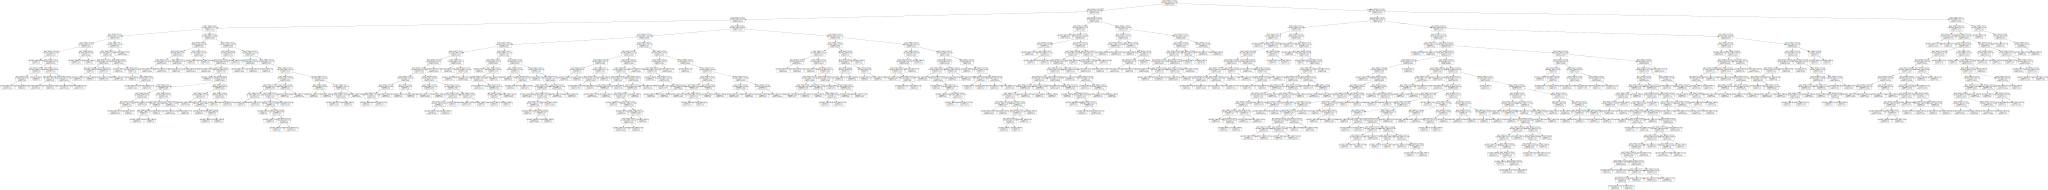

In [46]:
plot_regression_tree_sklearn(50)

### 4.2.2 Third Regression: Random Forest

Using Random Forest Regression to predict the `numOfRentedBikesHourly`.

In [47]:
# creating the regression model

forest_reg = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", random_state=42) 

In [48]:
#pipeline = pipeline_fit_predict(forest_reg, categoric, numeric, x_train, y_train, x_val, y_val)

**Looking for the best Hyperparameters**

In [63]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform
model_para = {'model__max_depth': range(1,51),
              'model__ccp_alpha': loguniform(1e-4, 40e-1)
             }

In [64]:
pipeline = pipeline_for_prediction(categoric, numeric, forest_reg)
#pipeline

In [65]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10, n_jobs=4)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 5/15; 22/50] END model__ccp_alpha=0.005938952698993865, model__max_depth=26;, score=-660.244 total time=   0.1s
[CV 3/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 3/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-756.000 total time=   0.1s
[CV 4/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 4/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-858.480 total time=   0.1s
[CV 5/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 5/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-692.873 total time=   0.1s
[CV 6/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 6/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-755.432 total time=   0.1s
[CV 4/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_de

[CV 11/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-654.790 total time=   0.1s
[CV 12/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 12/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-774.492 total time=   0.1s
[CV 13/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 13/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-531.640 total time=   0.1s
[CV 14/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 14/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-913.679 total time=   0.1s
[CV 12/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 12/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1085.851 total time=   0.0s
[CV 13/15; 24/50] START model__ccp_alpha=0.0012859191209139947, mode

[CV 15/15; 22/50] START model__ccp_alpha=0.005938952698993865, model__max_depth=26
[CV 15/15; 22/50] END model__ccp_alpha=0.005938952698993865, model__max_depth=26;, score=-794.429 total time=   0.1s
[CV 1/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 1/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-658.561 total time=   0.1s
[CV 2/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 2/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-722.138 total time=   0.1s
[CV 15/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 15/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-791.284 total time=   0.1s
[CV 1/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 1/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1099.858 total time= 

[CV 12/15; 43/50] END model__ccp_alpha=0.006565509530788613, model__max_depth=8;, score=-967.738 total time=   0.1s
[CV 13/15; 43/50] START model__ccp_alpha=0.006565509530788613, model__max_depth=8
[CV 13/15; 43/50] END model__ccp_alpha=0.006565509530788613, model__max_depth=8;, score=-720.048 total time=   0.1s
[CV 14/15; 43/50] START model__ccp_alpha=0.006565509530788613, model__max_depth=8
[CV 14/15; 43/50] END model__ccp_alpha=0.006565509530788613, model__max_depth=8;, score=-1206.921 total time=   0.1s
[CV 12/15; 44/50] START model__ccp_alpha=0.00010602617993118449, model__max_depth=11
[CV 12/15; 44/50] END model__ccp_alpha=0.00010602617993118449, model__max_depth=11;, score=-813.460 total time=   0.1s
[CV 13/15; 44/50] START model__ccp_alpha=0.00010602617993118449, model__max_depth=11
[CV 13/15; 44/50] END model__ccp_alpha=0.00010602617993118449, model__max_depth=11;, score=-540.769 total time=   0.1s
[CV 14/15; 44/50] START model__ccp_alpha=0.00010602617993118449, model__max_dep

[CV 4/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-961.710 total time=   0.1s
[CV 2/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 2/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-715.997 total time=   0.1s
[CV 3/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 3/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-752.462 total time=   0.1s
[CV 4/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 4/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-847.443 total time=   0.1s
[CV 5/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 5/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-685.453 total time=   0.1s
[CV 3/15; 47/50] START model__ccp_alpha=0.06147013349562105, model__max_depth=42
[CV 3/15; 47/50] END mo

[CV 11/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-767.477 total time=   0.1s
[CV 12/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 12/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-967.717 total time=   0.1s
[CV 10/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33
[CV 10/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-789.797 total time=   0.2s
[CV 11/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33
[CV 11/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-650.553 total time=   0.1s
[CV 12/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33
[CV 12/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-781.370 total time=   0.1s
[CV 13/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33
[CV 13/15; 46/

[CV 5/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-670.602 total time=   0.1s
[CV 6/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 6/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-742.760 total time=   0.1s
[CV 13/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 13/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-519.218 total time=   0.1s
[CV 14/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 14/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-885.793 total time=   0.1s
[CV 6/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[CV 6/15; 16/50] END model__ccp_alpha=0.07012122794606233, model__max_depth=44;, score=-747.859 total time=   0.1s
[CV 7/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[C

[CV 9/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[CV 9/15; 16/50] END model__ccp_alpha=0.07012122794606233, model__max_depth=44;, score=-811.164 total time=   0.1s
[CV 1/15; 17/50] START model__ccp_alpha=0.023256145462018832, model__max_depth=3
[CV 1/15; 17/50] END model__ccp_alpha=0.023256145462018832, model__max_depth=3;, score=-2164.491 total time=   0.0s
[CV 2/15; 17/50] START model__ccp_alpha=0.023256145462018832, model__max_depth=3
[CV 2/15; 17/50] END model__ccp_alpha=0.023256145462018832, model__max_depth=3;, score=-2032.174 total time=   0.0s
[CV 3/15; 17/50] START model__ccp_alpha=0.023256145462018832, model__max_depth=3
[CV 3/15; 17/50] END model__ccp_alpha=0.023256145462018832, model__max_depth=3;, score=-2032.910 total time=   0.0s
[CV 4/15; 17/50] START model__ccp_alpha=0.023256145462018832, model__max_depth=3
[CV 4/15; 17/50] END model__ccp_alpha=0.023256145462018832, model__max_depth=3;, score=-2046.714 total time=   0.0s
[CV 9/15; 17/50]

Best neg_mean_squared_error Score was: -754.6093555640746
The best hyper parameters for the model are:
{'model__ccp_alpha': 0.005938952698993865, 'model__max_depth': 26}


**Training & Evaluation of the model with the best hyperparameters**

In [61]:
forest_reg_end = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", ccp_alpha = 0.005938952698993865,
                                       max_depth = 26)

In [62]:
pipeline_end = pipeline_fit_predict(forest_reg_end, categoric, numeric, x_train, y_train, x_test, y_test)

MODEL SCORES:
MAE:  14.060
MSE:  616.828
RMSE:  24.836
Accuracy: 79.1 %
R2:  86.170 %
Max Residual Error:  267.208


### Fourth Regression: Lasso Regression

Using Lasso Regression to predict the `numOfRentedBikesHourly`.

In [54]:
# creating the regression model

lasso_reg = Lasso()

In [55]:
#pipeline = pipeline_fit_predict(lasso_reg, categoric, numeric, x_train, y_train, x_val, y_val)

**Looking for the best Hyperparameters**

In [56]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform
model_para = {'model__alpha': loguniform(1e-2, 1e2),
              'model__tol' : loguniform(1e-5,1e0)
             }

In [57]:
pipeline = pipeline_for_prediction(categoric, numeric, lasso_reg)
#pipeline

In [58]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 1/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1228.617 total time=   0.0s
[CV 2/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 2/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1491.261 total time=   0.0s
[CV 3/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 3/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1205.895 total time=   0.0s
[CV 4/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 4/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1607.555 total time=   0.0s
[CV 5/15; 1/50] START model__alpha=0.314891164795686, model

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-2800.690 total time=   0.0s
[CV 2/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 2/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-3061.228 total time=   0.0s
[CV 3/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 3/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-2896.223 total time=   0.0s
[CV 4/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 4/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-3368.280 total time=   0.0s
[CV 5/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 5/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-3118.510 total time=   0.0s
[CV 6/15; 2/50] START model__alpha=8.47180141881997

[CV 2/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2605.423 total time=   0.0s
[CV 3/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 3/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2459.729 total time=   0.0s
[CV 4/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 4/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2848.423 total time=   0.0s
[CV 5/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 5/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2629.450 total time=   0.0s
[CV 6/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 6/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2456.639 total time=   0.0s
[CV 7/15; 5/50] START model__alpha=2.53781550826566

[CV 13/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4183.200 total time=   0.0s
[CV 14/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 14/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4671.926 total time=   0.0s
[CV 15/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 15/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4357.022 total time=   0.0s
[CV 1/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 1/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1224.708 total time=   0.0s
[CV 2/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 2/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1464.914 total time=   0.0s
[CV 3/15; 8/50] STA

[CV 7/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1470.223 total time=   0.0s
[CV 8/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 8/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1487.580 total time=   0.0s
[CV 9/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 9/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1674.228 total time=   0.0s
[CV 10/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 10/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1696.042 total time=   0.0s
[CV 11/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 11/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1361.882 total time=   0.0s
[CV 12/15; 

[CV 2/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1729.122 total time=   0.0s
[CV 3/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 3/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1446.017 total time=   0.0s
[CV 4/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 4/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1832.146 total time=   0.0s
[CV 5/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 5/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1636.565 total time=   0.0s
[CV 6/15; 13/50] START model__alpha=0.6672367170464204, model__tol=0.08431013932082461
[CV 6/15; 13/50] END model__alpha=0.6672367170464204, model__tol=0.08431013932082461;, score=-1515.111 total time=   0.0s
[CV 7/15; 13/50] START model__alpha=0.6672

[CV 4/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2859.371 total time=   0.0s
[CV 5/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 5/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2642.224 total time=   0.0s
[CV 6/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 6/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2463.452 total time=   0.0s
[CV 7/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 7/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2645.356 total time=   0.0s
[CV 8/15; 16/50] START model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05
[CV 8/15; 16/50] END model__alpha=2.6926469100861774, model__tol=7.122305833333867e-05;, score=-2351.359 total time=   0.0s
[CV 9/15; 16/50] START m

[CV 13/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4279.768 total time=   0.0s
[CV 14/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 14/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4736.894 total time=   0.0s
[CV 15/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 15/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4448.105 total time=   0.0s
[CV 1/15; 19/50] START model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05
[CV 1/15; 19/50] END model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05;, score=-1227.548 total time=   0.0s
[CV 2/15; 19/50] START model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05
[CV 2/15; 19/50] END model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05;, score=-1477.921 total time=   0.0s
[CV 3/15; 19/50] START mod

[CV 9/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1430.282 total time=   0.0s
[CV 10/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 10/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1375.277 total time=   0.0s
[CV 11/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 11/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1224.469 total time=   0.0s
[CV 12/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 12/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1273.618 total time=   0.0s
[CV 13/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 13/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1145.569 total time=   0.0

[CV 6/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1283.280 total time=   0.0s
[CV 7/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 7/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1259.825 total time=   0.0s
[CV 8/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 8/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1367.293 total time=   0.0s
[CV 9/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 9/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1452.777 total time=   0.0s
[CV 10/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 10/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1427.985 total time=   0.0s
[CV 11/15; 24/50] STAR

[CV 3/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4279.768 total time=   0.0s
[CV 4/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 4/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4736.894 total time=   0.0s
[CV 5/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 5/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4448.105 total time=   0.0s
[CV 6/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 6/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-3992.944 total time=   0.0s
[CV 7/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 7/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4397.374 total time=   0.0s
[CV 8/15; 27/50] START model__alpha=57.279

[CV 12/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1272.806 total time=   0.1s
[CV 13/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 13/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1147.111 total time=   0.1s
[CV 14/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 14/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1552.114 total time=   0.1s
[CV 15/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 15/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1493.584 total time=   0.1s
[CV 1/15; 30/50] START model__alpha=0.0151673306880762, model__tol=0.00042330329965275956
[CV 1/15; 30/50] END model__alpha=0.0151673306880762, model__tol=0.00042330329965275956;, score=-1233.922 total time=   0.1s
[

[CV 14/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-4635.404 total time=   0.0s
[CV 15/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 15/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-4330.183 total time=   0.0s
[CV 1/15; 33/50] START model__alpha=0.1329652145729951, model__tol=0.0051698794422985386
[CV 1/15; 33/50] END model__alpha=0.1329652145729951, model__tol=0.0051698794422985386;, score=-1223.119 total time=   0.0s
[CV 2/15; 33/50] START model__alpha=0.1329652145729951, model__tol=0.0051698794422985386
[CV 2/15; 33/50] END model__alpha=0.1329652145729951, model__tol=0.0051698794422985386;, score=-1469.024 total time=   0.0s
[CV 3/15; 33/50] START model__alpha=0.1329652145729951, model__tol=0.0051698794422985386
[CV 3/15; 33/50] END model__alpha=0.1329652145729951, model__tol=0.0051698794422985386;, score=-1149.608 total time=   0.0s
[CV 4/15; 33/50] START m

[CV 10/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1368.680 total time=   0.0s
[CV 11/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 11/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1257.887 total time=   0.0s
[CV 12/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 12/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1297.490 total time=   0.0s
[CV 13/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 13/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1154.855 total time=   0.0s
[CV 14/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 14/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1531.820 total time=   0.0s
[CV 15/15; 35/50] START model__al

[CV 8/15; 38/50] END model__alpha=6.72093005015611, model__tol=0.04416068895118588;, score=-2654.825 total time=   0.0s
[CV 9/15; 38/50] START model__alpha=6.72093005015611, model__tol=0.04416068895118588
[CV 9/15; 38/50] END model__alpha=6.72093005015611, model__tol=0.04416068895118588;, score=-3225.525 total time=   0.0s
[CV 10/15; 38/50] START model__alpha=6.72093005015611, model__tol=0.04416068895118588
[CV 10/15; 38/50] END model__alpha=6.72093005015611, model__tol=0.04416068895118588;, score=-3016.040 total time=   0.0s
[CV 11/15; 38/50] START model__alpha=6.72093005015611, model__tol=0.04416068895118588
[CV 11/15; 38/50] END model__alpha=6.72093005015611, model__tol=0.04416068895118588;, score=-2572.299 total time=   0.0s
[CV 12/15; 38/50] START model__alpha=6.72093005015611, model__tol=0.04416068895118588
[CV 12/15; 38/50] END model__alpha=6.72093005015611, model__tol=0.04416068895118588;, score=-2813.945 total time=   0.0s
[CV 13/15; 38/50] START model__alpha=6.72093005015611,

[CV 12/15; 41/50] END model__alpha=28.340904295147727, model__tol=0.013076473382928538;, score=-4397.374 total time=   0.0s
[CV 13/15; 41/50] START model__alpha=28.340904295147727, model__tol=0.013076473382928538
[CV 13/15; 41/50] END model__alpha=28.340904295147727, model__tol=0.013076473382928538;, score=-4279.768 total time=   0.0s
[CV 14/15; 41/50] START model__alpha=28.340904295147727, model__tol=0.013076473382928538
[CV 14/15; 41/50] END model__alpha=28.340904295147727, model__tol=0.013076473382928538;, score=-4736.894 total time=   0.0s
[CV 15/15; 41/50] START model__alpha=28.340904295147727, model__tol=0.013076473382928538
[CV 15/15; 41/50] END model__alpha=28.340904295147727, model__tol=0.013076473382928538;, score=-4448.105 total time=   0.0s
[CV 1/15; 42/50] START model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05
[CV 1/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1238.054 total time=   0.0s
[CV 2/15; 42/50] START

[CV 7/15; 44/50] END model__alpha=8.287522363768153, model__tol=0.015409457762881544;, score=-3065.305 total time=   0.0s
[CV 8/15; 44/50] START model__alpha=8.287522363768153, model__tol=0.015409457762881544
[CV 8/15; 44/50] END model__alpha=8.287522363768153, model__tol=0.015409457762881544;, score=-2802.947 total time=   0.0s
[CV 9/15; 44/50] START model__alpha=8.287522363768153, model__tol=0.015409457762881544
[CV 9/15; 44/50] END model__alpha=8.287522363768153, model__tol=0.015409457762881544;, score=-3376.643 total time=   0.0s
[CV 10/15; 44/50] START model__alpha=8.287522363768153, model__tol=0.015409457762881544
[CV 10/15; 44/50] END model__alpha=8.287522363768153, model__tol=0.015409457762881544;, score=-3146.238 total time=   0.0s
[CV 11/15; 44/50] START model__alpha=8.287522363768153, model__tol=0.015409457762881544
[CV 11/15; 44/50] END model__alpha=8.287522363768153, model__tol=0.015409457762881544;, score=-2693.751 total time=   0.0s
[CV 12/15; 44/50] START model__alpha=8

[CV 7/15; 47/50] END model__alpha=11.044350847124681, model__tol=0.0064030366526711706;, score=-3364.211 total time=   0.0s
[CV 8/15; 47/50] START model__alpha=11.044350847124681, model__tol=0.0064030366526711706
[CV 8/15; 47/50] END model__alpha=11.044350847124681, model__tol=0.0064030366526711706;, score=-3138.215 total time=   0.0s
[CV 9/15; 47/50] START model__alpha=11.044350847124681, model__tol=0.0064030366526711706
[CV 9/15; 47/50] END model__alpha=11.044350847124681, model__tol=0.0064030366526711706;, score=-3709.565 total time=   0.0s
[CV 10/15; 47/50] START model__alpha=11.044350847124681, model__tol=0.0064030366526711706
[CV 10/15; 47/50] END model__alpha=11.044350847124681, model__tol=0.0064030366526711706;, score=-3445.423 total time=   0.0s
[CV 11/15; 47/50] START model__alpha=11.044350847124681, model__tol=0.0064030366526711706
[CV 11/15; 47/50] END model__alpha=11.044350847124681, model__tol=0.0064030366526711706;, score=-2978.366 total time=   0.0s
[CV 12/15; 47/50] ST

[CV 1/15; 50/50] END model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05;, score=-1234.756 total time=   0.1s
[CV 2/15; 50/50] START model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05
[CV 2/15; 50/50] END model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05;, score=-1474.630 total time=   0.1s
[CV 3/15; 50/50] START model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05
[CV 3/15; 50/50] END model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05;, score=-1151.187 total time=   0.1s
[CV 4/15; 50/50] START model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05
[CV 4/15; 50/50] END model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05;, score=-1607.962 total time=   0.1s
[CV 5/15; 50/50] START model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05
[CV 5/15; 50/50] END model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05;, score=-1293.561 total time=   0.1s
[CV 6/

**Training & Evaluation of the model with the best hyperparameters**

In [59]:
lasso_reg_end = Lasso(alpha=0.10842262717330158, tol = 0.020540519425388454)

In [60]:
pipeline_end = pipeline_fit_predict(lasso_reg_end, categoric, numeric, x_train, y_train, x_test, y_test)

MODEL SCORES:
MAE:  26.668
MSE:  1365.435
RMSE:  36.952
Accuracy: 60.35 %
R2:  69.385 %
Max Residual Error:  182.388


### 4.2.3 Artificial Neural Network

- Before running you have to install tensorflow: `pip install tensorflow`

**(Feature engineering)**

In [33]:
dfPhiladelphia['start_time_hourly'] = dfPhiladelphia['start_time_hourly'].astype(str)
dfPhiladelphia['start_month'] = dfPhiladelphia['start_month'].astype(str)
dfPhiladelphia['start_day'] = dfPhiladelphia['start_day'].astype(str)

In [34]:
dfPhiladelphia = pd.get_dummies(dfPhiladelphia)
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 84 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isWeekend               8760 non-null   bool   
 1   isHoliday               8760 non-null   bool   
 2   isRushhour              8760 non-null   bool   
 3   max_temp                8760 non-null   float64
 4   isPrecip                8760 non-null   bool   
 5   numOfRentedBikesHourly  8760 non-null   float64
 6   start_month_1           8760 non-null   uint8  
 7   start_month_10          8760 non-null   uint8  
 8   start_month_11          8760 non-null   uint8  
 9   start_month_12          8760 non-null   uint8  
 10  start_month_2           8760 non-null   uint8  
 11  start_month_3           8760 non-null   uint8  
 12  start_month_4           8760 non-null   uint8  
 13  start_month_5           8760 non-null   uint8  
 14  start_month_6           8760 non-null   

In [35]:
from sklearn.model_selection import train_test_split

#split the data set in 70% training set and 30% testing set
#x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(dfPhiladelphia.drop('numOfRentedBikesHourly', axis=1)
                                                    , dfPhiladelphia['numOfRentedBikesHourly'], 
                                                    test_size=0.3,random_state=42)

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

In [36]:
# Normalizing training data

st_scaler = StandardScaler()
st_scaler.fit(x_train)
x_train = st_scaler.transform(x_train)

st_scaler = StandardScaler()
st_scaler.fit(x_val)
x_val = st_scaler.transform(x_val)

**Building the model with the functional API of Keras:**

In [37]:
#pip install tensorflow

In [38]:
# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers

In [47]:
###### INTEGRATE HYPERPARAMTERTUNING TIPPS!
###### RELU IN EACH LAYER?

def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(83,)) # shapesize dependent of input features
    
    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)
    
    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='system_level_bike_rental_demand_philadelphia')
    
    # Compile the model
    model_ann.compile(optimizer='Adamax', loss='mean_squared_error') # MAYBE TRY DIFFERENT OPTIMIZER
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

You need to install keras_tuner first: You can use `pip install keras-tuner`

In [48]:
#pip install keras-tuner

In [49]:
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

Instantiate a tuner for hyperparametertuning:

- We choose the HyperBand Tuner from Keras

In [50]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    #directory = os.path.normpath('C:/#######')
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Show a summary of the search space:

In [51]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': None}


To clear the training outputs after each training step define a callback:

In [52]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Hyperparameter Search:

In [53]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Trial 30 Complete [00h 00m 10s]
val_loss: 728.2757568359375

Best val_loss So Far: 475.5929260253906
Total elapsed time: 00h 02m 24s
INFO:tensorflow:Oracle triggered exit


Show a summary of the results which presents the best model, the hyperparameters and the metrics:

In [54]:
tuner.results_summary()

Results summary
Results in .\kerastuner_LOG
Showing 10 best trials
Trial summary
Hyperparameters:
hidden_layer_1_units: 192
total_added_hidden_layers: 7
hidden_layers_2_units: 224
hidden_layers_3_units: 192
hidden_layers_4_units: 224
hidden_layers_5_units: 32
hidden_layers_6_units: 128
hidden_layers_7_units: 224
hidden_layers_8_units: 32
hidden_layers_9_units: 160
hidden_layers_10_units: 32
hidden_layers_11_units: 32
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 475.5929260253906
Trial summary
Hyperparameters:
hidden_layer_1_units: 128
total_added_hidden_layers: 5
hidden_layers_2_units: 160
hidden_layers_3_units: 32
hidden_layers_4_units: 128
hidden_layers_5_units: 192
hidden_layers_6_units: 32
hidden_layers_7_units: 96
hidden_layers_8_units: 160
hidden_layers_9_units: 256
hidden_layers_10_units: 96
hidden_layers_11_units: 96
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 501.25
Trial summary
Hyperpar

Get optimal hyperparameters:

In [55]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 192 
and the total number of hidden layers is 8.



Get the best model:

In [56]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show a summary of the model:

In [57]:
model_ann.summary()

Model: "system_level_bike_rental_demand_philadelphia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 83)]              0         
                                                                 
 dense (Dense)               (None, 192)               16128     
                                                                 
 dense_1 (Dense)             (None, 224)               43232     
                                                                 
 dense_2 (Dense)             (None, 192)               43200     
                                                                 
 dense_3 (Dense)             (None, 224)               43232     
                                                                 
 dense_4 (Dense)             (None, 32)                7200      
                                                                 
 dense_5 (Dense)      

Plot the model as a graph:

You need to install pydot and graphivz. You can use: `conda install -c anaconda graphviz`and `conda install -c conda-forge python-graphviz` sequentially and `conda install -c conda-forge pydot`

In [58]:
#pip install pydot

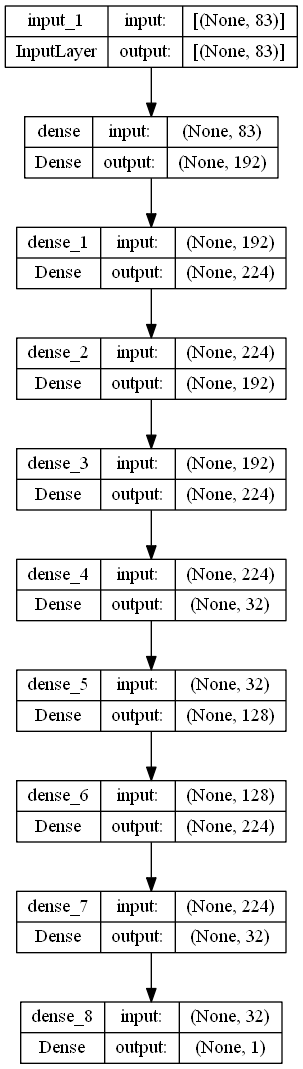

In [59]:
keras.utils.plot_model(model_ann, 'model_ann_system_level_bike_rental_demand_philadelphia.png', show_shapes=True)

**Train the model:**

In hyperparameter tuning the model was only trained with 20 epochs because of the performance. So now we continue the training to get a optimal result.

Define a callback which stops earlier when their is no further improvement and which avoids overfitting:

In [60]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50, 
    restore_best_weights=True 
    )

In [61]:
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
137/137 [==============================] - 1s 5ms/step - loss: 171.7243 - val_loss: 524.9036
Epoch 2/500
137/137 [==============================] - 0s 3ms/step - loss: 156.2939 - val_loss: 510.9396
Epoch 3/500
137/137 [==============================] - 1s 5ms/step - loss: 126.2992 - val_loss: 486.4974
Epoch 4/500
137/137 [==============================] - 0s 3ms/step - loss: 113.9595 - val_loss: 486.7390
Epoch 5/500
137/137 [==============================] - 0s 3ms/step - loss: 95.1725 - val_loss: 490.6350
Epoch 6/500
137/137 [==============================] - 1s 4ms/step - loss: 79.3498 - val_loss: 503.9344
Epoch 7/500
137/137 [==============================] - 1s 4ms/step - loss: 68.8776 - val_loss: 589.5743
Epoch 8/500
137/137 [==============================] - 0s 3ms/step - loss: 65.0057 - val_loss: 478.8373
Epoch 9/500
137/137 [==============================] - 1s 5ms/step - loss: 53.6317 - val_loss: 466.9374
Epoch 10/500
137/137 [==============================] - 1s 4

137/137 [==============================] - 0s 4ms/step - loss: 6.4755 - val_loss: 424.9109
Epoch 158/500
137/137 [==============================] - 0s 3ms/step - loss: 4.1815 - val_loss: 428.8619
Epoch 159/500
137/137 [==============================] - 0s 3ms/step - loss: 4.6816 - val_loss: 430.7204
Epoch 160/500
137/137 [==============================] - 0s 3ms/step - loss: 7.1081 - val_loss: 449.2701
Epoch 161/500
137/137 [==============================] - 0s 3ms/step - loss: 8.7277 - val_loss: 424.5110
Epoch 162/500
137/137 [==============================] - 0s 3ms/step - loss: 5.4713 - val_loss: 429.1885
Epoch 163/500
137/137 [==============================] - 0s 3ms/step - loss: 5.5661 - val_loss: 426.9390
Epoch 164/500
137/137 [==============================] - 0s 4ms/step - loss: 5.9022 - val_loss: 420.0863
Epoch 165/500
137/137 [==============================] - 0s 4ms/step - loss: 6.4512 - val_loss: 427.3834
Epoch 166/500
137/137 [==============================] - 0s 3ms/step 

137/137 [==============================] - 1s 4ms/step - loss: 3.8655 - val_loss: 412.7452
Epoch 314/500
137/137 [==============================] - 1s 4ms/step - loss: 5.1524 - val_loss: 407.0264
Epoch 315/500
137/137 [==============================] - 1s 4ms/step - loss: 3.3521 - val_loss: 414.4114
Epoch 316/500
137/137 [==============================] - 0s 3ms/step - loss: 3.7896 - val_loss: 405.5812
Epoch 317/500
137/137 [==============================] - 1s 4ms/step - loss: 2.5255 - val_loss: 402.9341
Epoch 318/500
137/137 [==============================] - 0s 3ms/step - loss: 2.3440 - val_loss: 405.3194
Epoch 319/500
137/137 [==============================] - 0s 3ms/step - loss: 3.0712 - val_loss: 408.5362
Epoch 320/500
137/137 [==============================] - 1s 4ms/step - loss: 4.4935 - val_loss: 407.6951
Epoch 321/500
137/137 [==============================] - 1s 4ms/step - loss: 4.1068 - val_loss: 407.6393
Epoch 322/500
137/137 [==============================] - 1s 4ms/step 

137/137 [==============================] - 0s 3ms/step - loss: 3.3968 - val_loss: 403.3133
Epoch 470/500
137/137 [==============================] - 0s 4ms/step - loss: 3.8423 - val_loss: 399.9793
Epoch 471/500
137/137 [==============================] - 0s 3ms/step - loss: 2.7685 - val_loss: 404.4626
Epoch 472/500
137/137 [==============================] - 0s 3ms/step - loss: 2.4626 - val_loss: 400.5894
Epoch 473/500
137/137 [==============================] - 0s 3ms/step - loss: 3.0398 - val_loss: 401.0799
Epoch 474/500
137/137 [==============================] - 0s 3ms/step - loss: 2.2576 - val_loss: 404.4636
Epoch 475/500
137/137 [==============================] - 0s 3ms/step - loss: 1.9941 - val_loss: 399.9461


**Evaluation of the performance of the model:**

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [63]:
st_scaler = StandardScaler()
st_scaler.fit(x_test)
x_test = st_scaler.transform(x_test)

In [64]:
pred_ann = model_ann.predict(x_test)

# Calculate MAE and RMSE
mae_ann = mean_absolute_error(y_test,pred_ann)
rmse_ann = mean_squared_error(y_test,pred_ann)**0.5

print("MAE:", mae_ann)
print("RMSE:", rmse_ann)
print("Accuracy:", round((1-(mae_ann/dfPhiladelphia["numOfRentedBikesHourly"].mean()))*100,2), "%")

83/83 [==============================] - 0s 1ms/step
MAE: 12.661117272624459
RMSE: 21.255194890455737
Accuracy: 81.18 %
